In [1]:
import os
os.chdir('../')


In [2]:
import torch

import matplotlib.pyplot as pyplot
import argparse
from dataset import make_loader
from models import methods, resnet
from models.methods import BaseMethod
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
METHOD_NAMES = [name for name in methods.__all__
                if not name.startswith('__') and callable(methods.__dict__[name])]
BACKBONE_NAMES = sorted(name for name in resnet.__all__
                        if name.islower() and not name.startswith("__")
                        and callable(resnet.__dict__[name]))
print(f"{METHOD_NAMES}")
print(f"{BACKBONE_NAMES}")

['BaseMethod', 'SD_Dropout', 'CS_KD', 'DDGSD', 'CS_KD_Dropout', 'DDGSD_Dropout', 'BYOT', 'BYOT_Dropout', 'DML', 'DML_Dropout', 'DML_Dropout_V1']
['byot_resnet18', 'byot_resnet18_cifar', 'resnet101', 'resnet152', 'resnet18', 'resnet18_cifar', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'wide_resnet101_2', 'wide_resnet50_2']


In [4]:
# dml byot 
class Args():
    num_workers = 1
    beta = 0
    aug = True
    batch_size = 128
    dataset = 'CIFAR100'
    method = 'BYOT'
    backbone = 'byot_resnet18_cifar'
    # byot baseline
    path_base = "saved_models/CIFAR100_BYOT_Dropout_byot_resnet18_cifar__p0.5_t3.0_alpha0.0_beta0.1_B128_seed41_detachFalse/checkpoint_last.pth.tar"
    # byot with self dropout
    path_drop = "saved_models/CIFAR100_BYOT_Dropout_byot_resnet18_cifar__p0.5_t3.0_alpha0.1_beta0.1_B128_seed41_detachFalse/checkpoint_last.pth.tar"

    
args = Args()


In [5]:
trainloader, testloader = make_loader(args.dataset, batch_size=args.batch_size, aug=args.aug, num_workers=args.num_workers)


Files already downloaded and verified
Files already downloaded and verified


In [6]:

############### Define Model ###############

## construct the model
num_classes = {'CIFAR10': 10, 'CIFAR100':100, 'CUB200':200, 'DOG':120}

# baseline
backbone = resnet.__dict__[args.backbone](num_classes=num_classes[args.dataset])
state_dict = torch.load(args.path_base)
model = methods.__dict__[args.method](args, backbone)
model.load_state_dict(state_dict['state_dict'])
model.cuda()

# baseline + self dropout
backbone = resnet.__dict__[args.backbone](num_classes=num_classes[args.dataset])
state_dict_drop = torch.load(args.path_drop)
model_drop = methods.__dict__[args.method](args, backbone)
model_drop.load_state_dict(state_dict_drop['state_dict'])
model_drop.cuda()

print('model load complete')
        


model load complete


In [7]:
model.eval()
pred = []
pred_drop = []
features = []
features_drop = []
Y = []

with torch.no_grad():
    for x, y in tqdm(testloader):
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

            outputs, feature = model(x, return_feat=True)

            pred.append(torch.softmax(outputs, dim=0).detach().cpu().numpy())
            # byot : last feature is feature[3]
            features.append(feature[3].detach().cpu().numpy()) 
            Y.append(y.detach().cpu().numpy())


            outputs_drop, feature_drop = model_drop(x, return_feat=True)
            pred_drop.append(torch.softmax(outputs_drop, dim=0).detach().cpu().numpy())
            features_drop.append(feature_drop[3].detach().cpu().numpy())



100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


In [8]:
Y = np.concatenate(Y)
pred = np.concatenate(pred)
pred_drop = np.concatenate(pred_drop)

features = np.concatenate(features)
features_drop = np.concatenate(features_drop)

features = features.squeeze()
features_drop = features_drop.squeeze()

In [9]:
from sklearn.manifold import TSNE


In [10]:
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(features)
tsne_em_drop = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(features_drop)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 1.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.106306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.324600
[t-SNE] KL divergence after 1000 iterations: 1.833614
[t-SNE] Computing 91 near

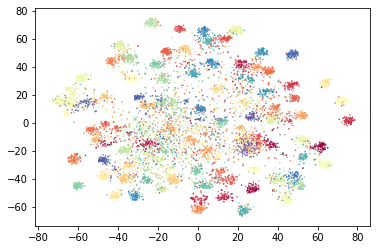

In [12]:
import matplotlib.pyplot as plt
plt.scatter(x=tsne_em[:,0], y=tsne_em[:,1], c=Y, cmap='Spectral', s=0.2)

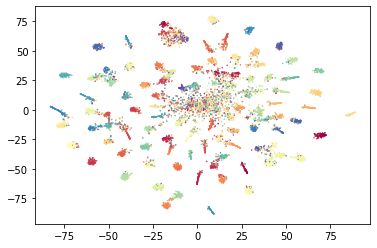

In [13]:
plt.scatter(x=tsne_em_drop[:,0], y=tsne_em_drop[:,1], c=Y, cmap='Spectral', s=0.2)